
# prediccion de incidentes viales en la ciudad de Medellin

## importacion librerias necesarias

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


## lectura y exploracion de los datos

In [2]:
#lectura dataframe saltando las filas malas
df=pd.read_csv("incidentes_viales.csv",on_bad_lines='skip',index_col=False,sep=";",encoding="UTF-8")
print(df.head())

    AÑO  CBML CLASE_ACCIDENTE      DIRECCION       DIRECCION ENCASILLADA  \
0  2015  1013  Caida Ocupante    CR 46 CL 43    CR  046   043  000 00000   
1  2015  1020          Choque  CR 43 A CL 29  CR  043 A   029  000 00000   
2  2015  0205            Otro    CR 46 CL 37    CR  046   037  000 00000   
3  2015  0101       Atropello   CR 34 CL 112    CR  034   112  000 00000   
4  2015  1504          Choque    CR 50 CL 14    CR  050   014  000 00000   

         DISEÑO  EXPEDIENTE      FECHA_ACCIDENTE          FECHA_ACCIDENTES  \
0  Tramo de via  A000259731  21/10/2015 05:58:00  2015-10-21T10:58:00.000Z   
1  Tramo de via  A000261725  05/11/2015 03:00:00  2015-11-05T08:00:00.000Z   
2  Tramo de via  A000259739  21/10/2015 07:40:00  2015-10-21T12:40:00.000Z   
3  Tramo de via  A000259752  21/10/2015 12:00:00  2015-10-21T17:00:00.000Z   
4  Tramo de via  A000259949  03/11/2015 06:16:00  2015-11-03T11:16:00.000Z   

  GRAVEDAD_ACCIDENTE  MES NRO_RADICADO NUMCOMUNA                     BARRI

C:\Users\johan\anaconda3\envs\tensorflow_gpu\lib\site-packages\IPython\core\interactiveshell.py:3552: DtypeWarning: Columns (0,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#revisamos las columnas
print(df.columns)
print("numero de columnas iniciales ",len(df.columns))
print("numero de filas iniciales ",df.shape[0])


Index(['AÑO', 'CBML', 'CLASE_ACCIDENTE', 'DIRECCION', 'DIRECCION ENCASILLADA',
       'DISEÑO', 'EXPEDIENTE', 'FECHA_ACCIDENTE', 'FECHA_ACCIDENTES',
       'GRAVEDAD_ACCIDENTE', 'MES', 'NRO_RADICADO', 'NUMCOMUNA', 'BARRIO',
       'COMUNA', 'LOCATION', 'X', 'Y'],
      dtype='object')
numero de columnas iniciales  18
numero de filas iniciales  270765


## limpieza de datos

In [4]:
#eliminacion de datos con nulos
df.dropna(inplace=True)
#eliminar datos duplicados
df.drop_duplicates(inplace=True)
print(df.shape[0])

250686


In [5]:
#AÑO-Año de ocurrencia del incidente
df["AÑO"]=df["AÑO"].apply(lambda x : re.findall(r"[0-9]{4}",str(x))[0])
print(df["AÑO"].unique())

['2015' '2014' '2016' '2017' '2018' '2019' '2020']


In [6]:
#CBML-Codigo catastral que corresponde al codigo comuna, barrio, manzana, lote catastral de un predio.
print(len(df["CBML"].unique()))

521


In [7]:
#CLASE_ACCIDENTE-Clasificación del IPAT sobre la clase de accidente de transito: choque, atropello, volcamiento,
#caida de ocupante, incendio, u otro (que no corresponde a las anteriores 5 clasificaciones, p. ej: sumersión)
df["CLASE_ACCIDENTE"]=df["CLASE_ACCIDENTE"].apply(lambda x : str(x).replace("Caída de Ocupante","Caida Ocupante").lower())
print((df["CLASE_ACCIDENTE"].unique()))

['caida ocupante' 'choque' 'otro' 'atropello' 'volcamiento' 'incendio']


In [8]:
#DIRECCION-Dirección donde ocurrió el incidente
##aparentemente se encuentra ya formateada
print((df["DIRECCION"].sample(10)))

49712        CL 60 CR 74 B
211433         CR 52 CL 94
10819          CL 57 CR 41
62825          CL 50 CR 54
204802         CR 65 TV 22
218623         CR 80 CL 57
241993       CL 86 CR 90 B
98758     CR 80 CL 2 A Sur
4526           CR 54 CL 34
170400         CL 80 CR 76
Name: DIRECCION, dtype: object


In [9]:
#DIRECCION ENCASILLADA-	Dirección encasillada que entrega el geocodificador
##aparentemente se encuentra ya formateada
##variable con poca informacion util dada la variable anterior--escoger una de las 2
print((df["DIRECCION ENCASILLADA"].sample(10)))

60742       CR  046   085  000 00000
83266     CL  025   065 B  000 00000
108100      CR  063   038  000 00000
5289        CL  067   055  000 00000
223590      CL  067   065  000 00000
79692     CL  050   081 B  000 00000
233209      CR  043   033  000 00000
136374      CR  049   043  000 00000
20241       CL  073   069  000 00000
99145       CR  064   074  000 00000
Name: DIRECCION ENCASILLADA, dtype: object


In [10]:
#DISENO-Sitio de la vía donde ocurrió el accidente: Cicloruta, Glorieta, Interseccion, Lote o Predio, Paso a Nivel, Paso Elevado,
#Paso Inferior, Pontón, Puente, Tramo de via, Tunel, Via peatonal
df["DISEÑO"]=df["DISEÑO"].apply(lambda x : str(x).replace("Pont\\xF3n","Pontón").lower())
print((df["DISEÑO"].unique()))

['tramo de via' 'interseccion' 'glorieta' 'lote o predio' 'paso a nivel'
 'puente' 'paso elevado' 'ciclo ruta' 'paso inferior' 'via peatonal'
 'pontón' 'tunel']


In [11]:
#EXPEDIENTE
#Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
##variable  aprarentemente con poco valor
print((df["EXPEDIENTE"].sample(10)))

266884    A001152838
218901    A000178446
10008     A000380454
106466    A000108077
263501    A001077144
194097    A000098573
222803    A000483043
48993     A000173773
224977    A000481890
69970     A001163623
Name: EXPEDIENTE, dtype: object


In [12]:
#FECHA_ACCIDENTE
#Fecha del accidente, proviene del IPAT - Informe Policial de accidente de Tránsito
df["FECHA_ACCIDENTE"] = pd.to_datetime(df["FECHA_ACCIDENTE"],dayfirst=True)
print((df["FECHA_ACCIDENTE"].sample(10)))

81175    2016-08-10 08:00:00
17333    2018-09-28 06:00:00
23033    2018-12-27 22:10:00
185281   2018-04-13 15:00:00
243184   2016-07-23 06:20:00
88326    2016-02-03 16:30:00
253588   2019-05-02 14:11:00
154570   2016-12-06 09:50:00
4535     2015-10-29 07:30:00
209724   2015-04-22 10:50:00
Name: FECHA_ACCIDENTE, dtype: datetime64[ns]


In [13]:
#FECHA_ACCIDENTES
#Fecha de los accidente (formato YYYY-MM-DD hh:mi:ss), proviene del IPAT - Informe Policial de accidentes de Tránsito
##veriable redundante con la anterior
print((df["FECHA_ACCIDENTES"].head(10)))

0    2015-10-21T10:58:00.000Z
1    2015-11-05T08:00:00.000Z
2    2015-10-21T12:40:00.000Z
3    2015-10-21T17:00:00.000Z
4    2015-11-03T11:16:00.000Z
5    2015-11-05T09:30:00.000Z
6    2015-10-18T09:40:00.000Z
7    2015-11-04T09:46:00.000Z
8    2015-10-21T12:00:00.000Z
9    2015-11-05T12:00:00.000Z
Name: FECHA_ACCIDENTES, dtype: object


In [14]:
#GRAVEDAD_ACCIDENTE
#Clasificación del IPAT - Informe Policial de Accidentes de Tránsito, sobre la gravedad del accidente, corresponde al resultado 
#más grave presentado en el accidente. Daños materiales "Sólo daños", accidente con heridos "Herido", accidente con muertos 
#"Muerto". No indica cantidad
df["GRAVEDAD_ACCIDENTE"]=df["GRAVEDAD_ACCIDENTE"].apply(lambda x : str(x).replace("Solo da\\xF1os","Solo daños").lower())
print((df["GRAVEDAD_ACCIDENTE"].unique()))

['con heridos' 'solo daños' 'con muertos']


In [15]:
#MES
#Mes de ocurrencia del incidente vial
print((df["MES"].unique()))

[10 11 12  9  4  3  5  6  7  8  1  2]


In [16]:
#NRO_RADICADO
#Consecutivo que asigna UNE, según el orden de llegada de los expedientes para su diligenciamiento
#no tiene mucho valor aparentemente para nuestros fines
print((df["NRO_RADICADO"].head()))

0    1508668
1    1510621
2    1508691
3    1508694
4    1510634
Name: NRO_RADICADO, dtype: object


In [17]:
#NUMCOMUNA
#Numero de la comununa en la que ocurrio incidente vial
print(df["NUMCOMUNA"].unique())

['10' '02' '01' '15' '14' '11' '07' '06' '04' '09' '05' '80' '13' '08'
 '16' '03' '12' '70' '60' '90' 'In' 'SN' '0' '50' 'AU' '5' '7' '9' '4' '3'
 '1' '2' '8' '6' 'Sin Inf']


In [18]:
#BARRIO
print(len(df["BARRIO"].unique()))
#Barrio de ocurrencia del incidente vial
#ó por o
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).lower().replace("\\xf3","o").replace("ó","o"))
#é por e 
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))
#á por a 
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))
#ñ
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xf1","ñ"))
#\\xed í por i
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xed","i").replace("í","i"))
#\\xfa ú por u
df["BARRIO"]=df["BARRIO"].apply(lambda x : str(x).replace("\\xfa","u").replace("ú","u"))
print((df["BARRIO"].unique()))

489
['barrio colon' 'san diego' 'la francia' 'santo domingo savio no. 1'
 'santa fe' 'la florida' 'los conquistadores' 'la alpujarra' 'villa nueva'
 'facultad de minas u. nacional' 'la esperanza' 'perpetuo socorro'
 'campo valdes no. 1' 'miraflores' 'oleoducto' 'terminal de transporte'
 'gerona' 'u.d. atanasio girardot' 'alejandro echavarria'
 'cabecera san antonio de prado' 'manila' 'los balsos no.2' 'moravia'
 'tenche' 'universidad nacional' 'los colores' 'caribe'
 'juan xxiii la quiebra' 'belalcazar' 'santa cruz' 'sucre' 'la candelaria'
 'el estadio' 'suramericana' 'la gloria' 'centro administrativo'
 'las estancias' 'aures no. 2' 'los angeles' 'castilla' 'la salle'
 'la america' 'picacho' 'bosques de san pablo' 'la aguacatala'
 'playon de los comuneros' 'estacion villa' 'la colina' 'popular'
 'villa del socorro' 'cucaracho' 'santa maria de los angeles'
 'el chagualo' 'la mansion' 'san benito' 'la castellana' 'jesus nazareno'
 'loreto' 'asomadera no. 1' 'el salvador' 'cristo rey' 'm

In [19]:
#COMUNA
#Denominación con la cual se identifica cada Comuna o Corregimiento. 01:Popular 02:Santa Cruz 03:Manrique 04:Aranjuez 05:Castilla 06:Doce de Octubre 07:Robledo 08:Villa Hermosa 09:Buenos Aires 10:La Candelaria 11:Laureles - Estadio 12:La América 13:San Javier 14:El Poblado 15:Guayabal 16:Belén 50:San Sebastián de Palmitas 60:San Cristobal 70:Altavista 80:San Antonio de Prado 90:Santa Elena 99:Toda la Ciudad
##variable redundante
#ó por o
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).lower().replace("\\xf3","o").replace("ó","o"))
#á por a 
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).replace("\\xc1","a").replace("\\xe1","a").replace("á","a"))
#é por e 
df["COMUNA"]=df["COMUNA"].apply(lambda x : str(x).replace("\\xe9","e").replace("é","e"))
print((df["COMUNA"].unique()))

['la candelaria' 'santa cruz' 'popular' 'guayabal' 'el poblado'
 'laureles estadio' 'robledo' 'doce de octubre' 'aranjuez' 'buenos aires'
 'castilla' 'corregimiento de san antonio de prado' 'san javier'
 'villa hermosa' 'belen' 'manrique' 'la america'
 'corregimiento de altavista' 'corregimiento de san cristobal'
 'corregimiento de santa elena' 'in' 'sn'
 'corregimiento de san sebastian de palmitas' '0' 'au']


In [20]:
#LOCATION
#Fuente de información con la cual se realizó la geocodificación
print((df["LOCATION"].head(10)))

0    [-75.5688011014, 6.24312304123]
1    [-75.5693883283, 6.22870030622]
2    [-75.5503911403, 6.29869502502]
3    [-75.5442195069, 6.30019383306]
4     [-75.578180998, 6.21699243701]
5      [-75.561118009, 6.2047775959]
6    [-75.5810144962, 6.24576066323]
7    [-75.5752597216, 6.24685341912]
8    [-75.5624178534, 6.25341454089]
9    [-75.5931430393, 6.27330476643]
Name: LOCATION, dtype: object


In [21]:
#X
#Coordenada X en metros del accidente, en sistema de coordenadas MAGNA Medellin Local
print(df["X"].head(10))

0    834949.69
1    834880.17
2    837004.94
3    837688.53
4    833903.11
5    835788.30
6    833598.49
7    834235.89
8    835659.53
9    832264.64
Name: X, dtype: float64


In [22]:
#Y
#Coordenada Y en metros del accidente, en sistema de coordenadas MAGNA Medellin Local
print(df["Y"].head(10))

0    1182357.34
1    1180762.02
2    1188499.17
3    1188663.05
4    1179469.60
5    1178113.02
6    1182652.97
7    1182772.04
8    1183493.83
9    1185703.90
Name: Y, dtype: float64


In [23]:
#Eliminar duplicados
df.drop_duplicates(inplace=True)
#borrar columnas con datos redudantes o poco aportantes
df.drop(labels=["DIRECCION ENCASILLADA","EXPEDIENTE","FECHA_ACCIDENTES","NRO_RADICADO","COMUNA"],axis=1,inplace=True)

In [24]:
df.to_csv("datosLimpios.csv")
#guardamos los datos en una nueva varible
data=df.copy()
df

,AÑO,CBML,CLASE_ACCIDENTE,DIRECCION,DISEÑO,FECHA_ACCIDENTE,GRAVEDAD_ACCIDENTE,MES,NUMCOMUNA,BARRIO,LOCATION,X,Y
0,2015,1013,caida ocupante,CR 46 CL 43,tramo de via,2015-10-21 05:58:00,con heridos,10,10,barrio colon,"[-75.5688011014, 6.24312304123]",834949.69,1182357.34
1,2015,1020,choque,CR 43 A CL 29,tramo de via,2015-11-05 03:00:00,solo daños,11,10,san diego,"[-75.5693883283, 6.22870030622]",834880.17,1180762.02
2,2015,0205,otro,CR 46 CL 37,tramo de via,2015-10-21 07:40:00,con heridos,10,02,la francia,"[-75.5503911403, 6.29869502502]",837004.94,1188499.17
3,2015,0101,atropello,CR 34 CL 112,tramo de via,2015-10-21 12:00:00,con heridos,10,01,santo domingo savio no. 1,"[-75.5442195069, 6.30019383306]",837688.53,1188663.05
4,2015,1504,choque,CR 50 CL 14,tramo de via,2015-11-03 06:16:00,solo daños,11,15,santa fe,"[-75.578180998, 6.21699243701]",833903.11,1179469.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
270760,2020,1004,caida ocupante,CR 62 CL 59,tramo de via,2020-08-31 18:50:00,con heridos,8,10,el chagualo,"[-75.5731343044, 6.26063534822]",834475.51,1184295.99
270761,2020,1115,otro,CL 50 CR 74,tramo de via,2020-08-31 18:50:00,con heridos,8,11,cuarta brigada,"[-75.5902062951, 6.26040455473]",832585.61,1184275.87
270762,2020,515,choque,CL 80 CR 65,tramo de via,2020-08-31 19:05:00,solo daños,8,5,cementerio universal,"[-75.5735398111, 6.27625838886]",834435.55,1186024.41
270763,2020,207,atropello,CL 104 CR 45,tramo de via,2020-08-31 19:30:00,con heridos,8,2,villa del socorro,"[-75.5515085985, 6.29359892373]",836879.66,1187935.77


In [25]:
#df=pd.read_csv("datosLimpios.csv")

## 1 - Entrenamiento de un modelo predictivo
Se deberá construir un modelo que permita predecir la accidentalidad por tipo de accidente a nivel semanal, mensual y diario. Para esto se deberán considerar fechas especiales.

In [26]:
df=data
df["DIA"]=df["FECHA_ACCIDENTE"].apply(lambda x: x.date())
df=df.groupby(["DIA","CLASE_ACCIDENTE"]).count()
df.reset_index(inplace=True)
df["CANTIDAD"]=df["AÑO"]
df=df[["DIA","CLASE_ACCIDENTE","CANTIDAD"]]
df

,DIA,CLASE_ACCIDENTE,CANTIDAD
0,2014-07-04,choque,22
1,2014-07-05,atropello,25
2,2014-07-05,caida ocupante,18
3,2014-07-05,choque,63
4,2014-07-05,otro,7
...,...,...,...
11155,2020-08-31,atropello,10
11156,2020-08-31,caida ocupante,5
11157,2020-08-31,choque,62
11158,2020-08-31,otro,8


In [27]:
import holidays_co as co
from datetime import timedelta
#dia_festivo 1 si 0 no
df["dia_festivo".upper()]=df["DIA"].apply(lambda x : int(co.is_holiday_date(x)))
#sigiente_dia_festivo
df["sigiente_dia_festivo".upper()]=df["DIA"].apply(lambda x : int(co.is_holiday_date(x+timedelta(days=1))))
#anterior_dia_festivo
df["anterior_dia_festivo".upper()]=df["DIA"].apply(lambda x : int(co.is_holiday_date(x-timedelta(days=1))))
df["AÑO"]=df["DIA"].apply(lambda x : pd.Timestamp(x).year)
df["dia_de_la_semana".upper()]=df["dia".upper()].apply(lambda x : pd.Timestamp(x).day_of_week)
min=df["DIA"].min()
df["dia_total".upper()]=df["dia".upper()].apply(lambda x : (x-min).days+1)
df.head(10)

,DIA,CLASE_ACCIDENTE,CANTIDAD,DIA_FESTIVO,SIGIENTE_DIA_FESTIVO,ANTERIOR_DIA_FESTIVO,AÑO,DIA_DE_LA_SEMANA,DIA_TOTAL
0,2014-07-04,choque,22,0,0,0,2014,4,1
1,2014-07-05,atropello,25,0,0,0,2014,5,2
2,2014-07-05,caida ocupante,18,0,0,0,2014,5,2
3,2014-07-05,choque,63,0,0,0,2014,5,2
4,2014-07-05,otro,7,0,0,0,2014,5,2
5,2014-07-05,volcamiento,3,0,0,0,2014,5,2
6,2014-07-06,atropello,14,0,0,0,2014,6,3
7,2014-07-06,caida ocupante,10,0,0,0,2014,6,3
8,2014-07-06,choque,40,0,0,0,2014,6,3
9,2014-07-06,otro,12,0,0,0,2014,6,3


Sea X el con junto de parametros 

### Entrenamiento y validación
Los modelos predictivos se deberán construir con los datos de los años 2014, 2015, 2016, 2018. Se usan los accidentes del año 2019 y 2020 (¡alerta!) para validar los modelos.
Se deberá analizar el comportamiento del modelo predictivo en los años 2021 y 2022 y explicar las posibles desviaciones.

In [28]:

train=df[(df["AÑO"]) <2019]
train=pd.concat([train,pd.get_dummies(train[["CLASE_ACCIDENTE"]],drop_first=True)], axis=1)
test=df.drop(train.index)
X_train=train[["CLASE_ACCIDENTE","DIA_FESTIVO","SIGIENTE_DIA_FESTIVO","ANTERIOR_DIA_FESTIVO","DIA_DE_LA_SEMANA","DIA_TOTAL"]]
X_train=pd.concat([X_train,pd.get_dummies(X_train[["CLASE_ACCIDENTE"]],drop_first=True)], axis=1)
X_train.drop(["CLASE_ACCIDENTE"],axis=1,inplace=True)
Y_train=train[["CANTIDAD"]]
X_test=test[["CLASE_ACCIDENTE","DIA_FESTIVO","SIGIENTE_DIA_FESTIVO","ANTERIOR_DIA_FESTIVO","DIA_DE_LA_SEMANA","DIA_TOTAL"]]
X_test=pd.concat([X_test,pd.get_dummies(X_test[["CLASE_ACCIDENTE"]],drop_first=True)], axis=1)
X_test.drop(["CLASE_ACCIDENTE"],axis=1,inplace=True)
Y_test=test[["CANTIDAD"]]

In [29]:
from sklearn.compose import make_column_selector
    # Importe make_column_transformer
from sklearn.compose import make_column_transformer
    # Importe SelectKBest
from sklearn.feature_selection import SelectKBest
    # Importe f_regression
from sklearn.feature_selection import f_regression
    # Importe LinearRegression
from sklearn.linear_model import LinearRegression
    # Importe GridSearchCV
from sklearn.model_selection import GridSearchCV
    # Importe Pipeline
from sklearn.pipeline import Pipeline
    # Importe OneHotEncoder
from sklearn.preprocessing import OneHotEncoder


pipeline = Pipeline(
        steps=[
            # Paso 1: Construya un column_transformer que aplica OneHotEncoder a las
            # variables categóricas, y no aplica ninguna transformación al resto de
            # las variables.
            (
                "column_transfomer",
                make_column_transformer(
                    (
                        OneHotEncoder(),
                        make_column_selector(dtype_include=object),
                    ),
                    remainder='passthrough',
                ),
            ),
            # Paso 2: Construya un selector de características que seleccione las K
            # características más importantes. Utilice la función f_regression.
            (
                "selectKBest",
                SelectKBest(score_func=f_regression),
            ),
            # Paso 3: Construya un modelo de regresión lineal.
            (
                "linearRegression",
                LinearRegression(),
            ),
        ],
    )

In [30]:
 param_grid = {
        "selectKBest__k": (1, 9),
    }

In [31]:
gridSearchCV = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring="neg_mean_squared_error",
        refit=True,
        return_train_score=True,
    )

In [32]:
gridSearchCV.fit(X_train, Y_train.values.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('column_transfomer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x00000246B8A57B88>)])),
                                       ('selectKBest',
                                        SelectKBest(score_func=<function f_regression at 0x00000246BF0009D8>)),
                                       ('linearRegression',
                                        LinearRegression())]),
             param_grid={'selectKBest__k': (1, 9)}, return_train_score=True,
             scoring='neg_mean_squared_error')

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Evalúe el modelo con los conjuntos de entrenamiento y prueba.
Y_train_pred = gridSearchCV.predict(X_train)
Y_test_pred = gridSearchCV.predict(X_test)

    # Compute el error cuadratico medio de entrenamiento y prueba. Redondee los
    # valores a dos decimales.

mse_train = r2_score(
        Y_train,
        Y_train_pred,
    ).round(2)

mse_test = r2_score(
        Y_test,
        Y_test_pred,
    ).round(2)

In [34]:
print(mse_test,mse_train)

0.74 0.89


In [35]:
X_train

,DIA_FESTIVO,SIGIENTE_DIA_FESTIVO,ANTERIOR_DIA_FESTIVO,DIA_DE_LA_SEMANA,DIA_TOTAL,CLASE_ACCIDENTE_caida ocupante,CLASE_ACCIDENTE_choque,CLASE_ACCIDENTE_incendio,CLASE_ACCIDENTE_otro,CLASE_ACCIDENTE_volcamiento
0,0,0,0,4,1,0,1,0,0,0
1,0,0,0,5,2,0,0,0,0,0
2,0,0,0,5,2,1,0,0,0,0
3,0,0,0,5,2,0,1,0,0,0
4,0,0,0,5,2,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
8134,0,1,0,0,1642,0,0,0,0,0
8135,0,1,0,0,1642,1,0,0,0,0
8136,0,1,0,0,1642,0,1,0,0,0
8137,0,1,0,0,1642,0,0,0,1,0


In [36]:
train_stats = train.describe()
train_stats.pop("CANTIDAD")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
DIA_FESTIVO,8139.0,0.048777,0.215416,0.0,0.0,0.0,0.0,1.0
SIGIENTE_DIA_FESTIVO,8139.0,0.048286,0.214383,0.0,0.0,0.0,0.0,1.0
ANTERIOR_DIA_FESTIVO,8139.0,0.048777,0.215416,0.0,0.0,0.0,0.0,1.0
AÑO,8139.0,2016.226809,1.309704,2014.0,2015.0,2016.0,2017.0,2018.0
DIA_DE_LA_SEMANA,8139.0,2.996560,1.999751,0.0,1.0,3.0,5.0,6.0
DIA_TOTAL,8139.0,822.537412,473.192550,1.0,414.0,822.0,1231.0,1642.0
CLASE_ACCIDENTE_caida ocupante,8139.0,0.201499,0.401144,0.0,0.0,0.0,0.0,1.0
CLASE_ACCIDENTE_choque,8139.0,0.201745,0.401327,0.0,0.0,0.0,0.0,1.0
CLASE_ACCIDENTE_incendio,8139.0,0.002457,0.049513,0.0,0.0,0.0,0.0,1.0
CLASE_ACCIDENTE_otro,8139.0,0.201622,0.401236,0.0,0.0,0.0,0.0,1.0


In [37]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = (X_train)
normed_test_data = (Y_test)

In [38]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(X_train.keys())]),
    
    
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_absolute_percentage_error',
                optimizer=optimizer,
                metrics=['mae', 'mse',"mean_absolute_percentage_error"])
  return model

In [39]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                704       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [40]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.2502415 ],
       [-0.46379146],
       [-0.64627963],
       [-0.4520113 ],
       [-0.53508127],
       [-0.6522737 ],
       [-0.6356083 ],
       [-0.80965346],
       [-0.65405226],
       [-0.680505  ]], dtype=float32)

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print("\n",epoch,logs)
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, Y_train,
  epochs=EPOCHS, validation_split = 0, verbose=0,
  callbacks=[PrintDot()])


 0 {'loss': 34.23952865600586, 'mae': 5.044826984405518, 'mse': 65.584716796875, 'mean_absolute_percentage_error': 34.23952865600586}
....................................................................................................
 100 {'loss': 34.078548431396484, 'mae': 5.051471710205078, 'mse': 65.79812622070312, 'mean_absolute_percentage_error': 34.078548431396484}
....................................................................................................
 200 {'loss': 34.1243782043457, 'mae': 5.064464569091797, 'mse': 66.24626922607422, 'mean_absolute_percentage_error': 34.1243782043457}
....................................................................................................
 300 {'loss': 34.0118293762207, 'mae': 5.008752822875977, 'mse': 64.0704345703125, 'mean_absolute_percentage_error': 34.0118293762207}
....................................................................................................
 400 {'loss': 34.176700592041016, 'mae': 5.0034627

In [42]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,mean_absolute_percentage_error,epoch
995,34.132874,5.024364,64.046349,34.132874,995
996,34.272755,5.037130,66.535622,34.272755,996
997,34.180283,5.066350,65.243805,34.180283,997
998,34.118473,5.064072,65.990898,34.118473,998
999,34.232449,5.044401,65.252777,34.232449,999


In [43]:

from sklearn.metrics import r2_score
# Evalúe el modelo con los conjuntos de entrenamiento y prueba.
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

    # Compute el error cuadratico medio de entrenamiento y prueba. Redondee los
    # valores a dos decimales.

mse_train = r2_score(
        Y_train,
        Y_train_pred,
    ).round(2)

mse_test = r2_score(
        Y_test,
        Y_test_pred,
    ).round(2)

In [44]:
print(mse_test,mse_train)

0.8 0.92


In [45]:
error=tf.keras.metrics.mean_absolute_percentage_error(
    Y_train, Y_train_pred)
model.evaluate(X_train,Y_train)

255/255 [==============================] - 1s 2ms/step - loss: 33.2500 - mae: 5.0421 - mse: 65.9206 - mean_absolute_percentage_error: 33.2500


[33.25001907348633, 5.042057037353516, 65.9205551147461, 33.25001907348633]

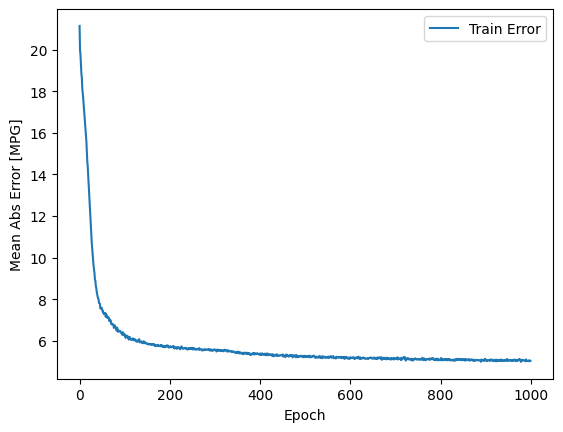

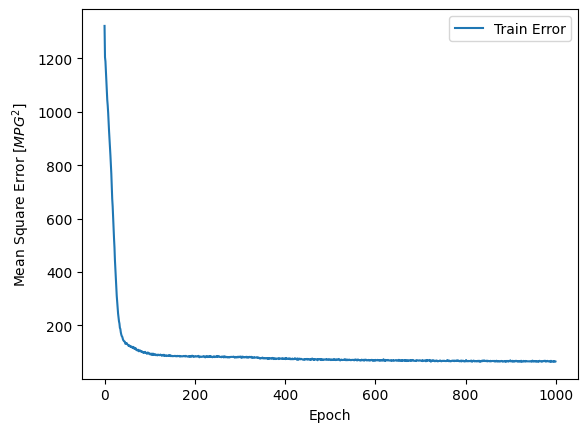

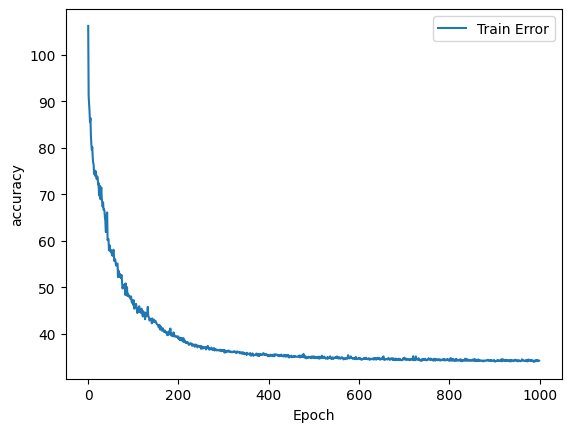

In [46]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  #plt.plot(hist['epoch'], hist['val_mae'],
  #         label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  #plt.plot(hist['epoch'], hist['val_mse'],
  #         label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('accuracy')
  plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
  #plt.plot(hist['epoch'], hist['val_mse'],
  #         label = 'Val Error')
  #plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)



 0 {'loss': 33.56283187866211, 'mae': 5.098353385925293, 'mse': 66.74028015136719, 'mean_absolute_percentage_error': 33.56283187866211, 'val_loss': 36.4306755065918, 'val_mae': 4.662623882293701, 'val_mse': 58.64480972290039, 'val_mean_absolute_percentage_error': 36.4306755065918}
...........

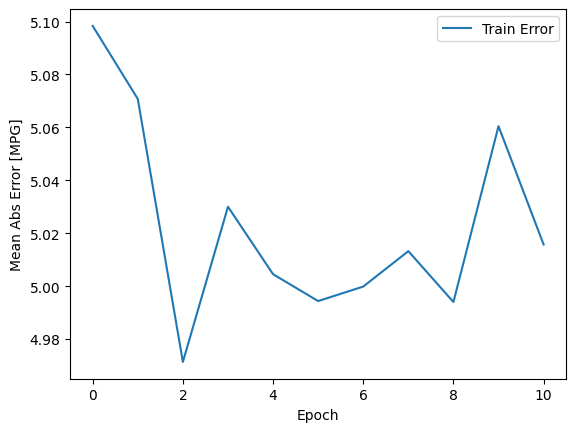

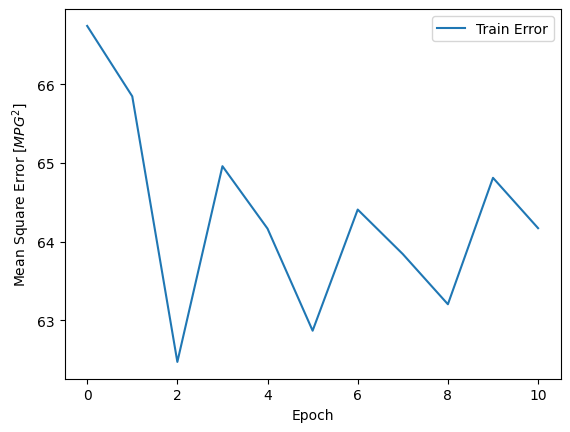

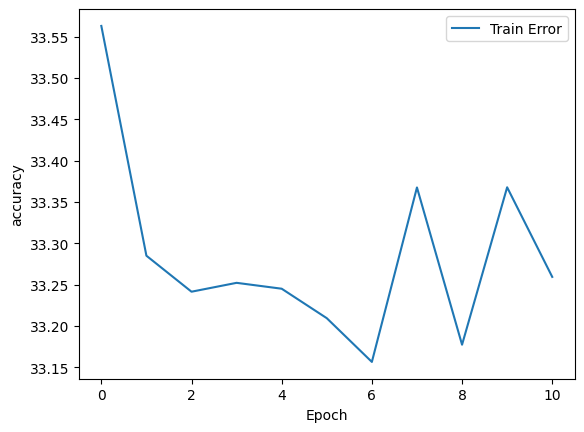

In [47]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, Y_train, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [48]:
#model.save('modelodias.h5')

In [49]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(
        Y_train,
        Y_train_pred,
    ).round(2)

mae_test = mean_absolute_error(
        Y_test,
        Y_test_pred,
    ).round(2)

In [50]:
print(mae_train,mae_test)

5.04 7.12


In [51]:
from sklearn.metrics import mean_absolute_percentage_error
mape_train = mean_absolute_percentage_error(
        Y_train,
        Y_train_pred,
    ).round(2)

mape_test = mean_absolute_percentage_error(
        Y_test,
        Y_test_pred,
    ).round(2)

In [52]:
print(mape_train,mape_test)

0.33 0.56
